**ReadMe**

The question 1 is answered in part 1.

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
%cd /content/drive/My\ Drive/Winter\ 2022/CME241

Mounted at /content/drive
/content/drive/My Drive/Winter 2022/CME241


In [2]:
from rl.distribution import *
from rl.function_approx import *
from rl.markov_decision_process import *
from rl.policy import *
from rl.dynamic_programming import *
from scipy.stats import poisson, norm
import numpy as np
from itertools import islice
from rl.gen_utils.plot_funcs import plot_list_of_curves
import matplotlib.pyplot as plt
import time
from typing import Tuple, Sequence, Iterator, List
from __future__ import annotations

#1. Univariate BSpline

In [5]:
#X-Input: float
#Y-Output:float
@dataclass(frozen=True)
class UnivariateBSplineApprox(FunctionApprox[float]):
    degree: int
    knots: np.ndarray = field(default_factory=lambda: np.array([]))
    coeffs: np.ndarray = field(default_factory=lambda: np.array([]))

    def representational_gradient(self, x_value: float) -> UnivariateBSplineApprox:
        eps: float = 1e-6
        one_hots: np.array = np.eye(len(self.coeffs))
        coeffs_grad=np.array([(BSpline(self.knots, c + one_hots[i] * eps, self.degree)(x_value) - BSpline(self.knots,c - one_hots[i] * eps,self.degree)(x_value)) / (2 * eps) for i, c in enumerate(self.coeffs)])
        
    def objective_gradient(
        self,
        xy_vals_seq: Iterable[Tuple[float, float]],
        obj_deriv_out_fun: Callable[[Sequence[float], Sequence[float]], float]
    ) -> Gradient[UnivariateBSplineApprox]:
        return Gradient(replace(self, coeffs=np.zeros_like(self.coeffs)))

    def evaluate(self, x_values_seq: Iterable[float]) -> np.ndarray:
        spline_func: Callable[[Sequence[float]], np.ndarray] = \
            BSpline(self.knots, self.coeffs, self.degree)
        return spline_func(x_values_seq)

    def update(
        self,
        xy_vals_seq: Iterable[Tuple[float, float]]
    ) -> BSplineApprox[X]:
        sorted_pairs: Sequence[Tuple[float, float]] = sorted(xy_vals_seq)
        new_knots, new_coeffs, _ = splrep([f for f, _ in sorted_pairs], [y for _, y in sorted_pairs], k=self.degree)
        return replace(self, knots=new_knots, coeffs=new_coeffs)

    def solve(
        self,
        xy_vals_seq: Iterable[Tuple[float, float]],
    ) -> BSplineApprox[X]:
        return self.update(xy_vals_seq)

    def within(self, other: FunctionApprox[float], tolerance: float) -> bool:
        if isinstance(other, UnivariateBSplineApprox):
            return np.all(np.abs(self.knots - other.knots) <= tolerance).item() and np.all(np.abs(self.coeffs - other.coeffs) <= tolerance).item()
        return False

    def __add__(self, other: UnivariateBSplineApprox) -> UnivariateBSplineApprox:
        return replace(self, knots = self.knots + other.knots, coeffs = self.coeffs + other.coeffs)

    def __mul__(self, scalar: float) -> UnivariateBSplineApprox:
        return replace(self, knots = scalar*self.knots, coeffs = scalar*self.coeffs)

    def update_with_gradient(self, gradient: Gradient[UnivariateBSplineApprox]) -> UnivariateBSplineApprox:
        return replace(self, coeffs=self.update(gradient.function_approx.coeffs))

Linear Model RMSE = 0.989
Spline Model RMSE = 0.357


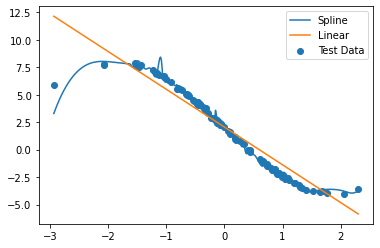

In [7]:
#Type of X-input
input_type = float
#Type of X-input concatenated with Y-output
input_output_type = Tuple[float, float]
#Sequence of X-input and Y-output pair
DataSeq = Sequence[Tuple[input_type, float]]

def example_model_data_generator() -> Iterator[Tuple[input_type, float]]:
  coeffs: input_output_type = (2., -6.)
  d = norm(loc=0., scale=0.1)
  while True:
    pt: float = np.random.randn()
    x_val: input_type = pt
    y_val: float = coeffs[0] + coeffs[1] * np.sin(pt/1.2) + d.rvs(size=1)[0]
    yield tuple((x_val, y_val))

def data_seq_generator(data_generator: Iterator[Tuple[input_type, float]], num_pts: int) -> Iterator[DataSeq]:
  while True:
    pts: DataSeq = list(islice(data_generator, num_pts))
    yield pts

def feature_functions():
  return [lambda _: 1., lambda x: x]

def adam_gradient():
  return AdamGradient(learning_rate=1, decay1=0.9, decay2=0.999)

def get_linear_model() -> LinearFunctionApprox[input_type]:
    ffs = feature_functions()
    ag = adam_gradient()
    return LinearFunctionApprox.create(feature_functions=ffs, adam_gradient=ag, regularization_coeff=0., direct_solve=True)

training_num_pts: int = 70
test_num_pts: int = 100
data_gen: Iterator[Tuple[input_type, float]] = example_model_data_generator()
training_data_gen: Iterator[DataSeq] = data_seq_generator(data_gen, training_num_pts)
test_data: DataSeq = list(islice(data_gen, test_num_pts))

train_data = next(training_data_gen)

Linear = get_linear_model()
Linear = Linear.solve(train_data)
Linear_rmse: float = Linear.rmse(test_data)
print(f"Linear Model RMSE = {Linear_rmse:.3f}")

Spline = UnivariateBSplineApprox(3)
Spline = Spline.solve(train_data)
Spline_rmse: float = Spline.rmse(test_data)
print(f"Spline Model RMSE = {Spline_rmse:.3f}")

x_plot, y_plot = zip(*test_data)

max_x = max(x_plot)
min_x = min(x_plot)

spline_x_plot = np.linspace(min_x, max_x, 400)
spline_y_plot = Spline.evaluate(spline_x_plot)

linear_y_plot = Linear.evaluate(spline_x_plot)

plt.plot(spline_x_plot, spline_y_plot, label='Spline')
plt.plot(spline_x_plot, linear_y_plot, label='Linear')
plt.scatter(x_plot, y_plot, label='Test Data')
plt.legend()
plt.show()